### Preamble

In [ ]:
import $ivy.`org.scalatest::scalatest:3.2.16`
import org.scalatest.{Filter => _, _}, flatspec._, matchers._

# Topic 7. Applications

## 7.3 Games

In this section we will exploit ADTs and higher-order functions to implement the game of Wordle. In doing so, we will also emphasise the general design patterns that can be applied to implement these kinds of applications.  

##### Wordle specification

Wordle is a popular online word game that challenges players to guess a five-letter word within six tries. Each guess must be a valid five-letter word. After each guess, the game provides feedback in the form of colored tiles, indicating how close the guess was to the word. A green tile shows that a letter is correct and in the right position, a yellow tile indicates that the letter is correct but in the wrong position, and a gray tile means that the letter is not in the word at all. The goal is to guess the correct word in as few tries as possible.

For instance, this a game in which the correct word ("slice") was guessed in three attempts: 

- Guess 1: CRANE
  - 🟨⬛⬛⬛🟩
- Guess 2: PIOUS
  - ⬛🟨⬛⬛🟨
- Guess 3: SLICE
  - 🟩🟩🟩🟩🟩

In the first guess, "CRANE", the first letter is marked with a yellow tile since it appears in the word "SLICE" in a different position; the letters "R", "A" and "N" do not appear, and they are marked with a gray tile accordingly; last, the letter "E" appears in the right position and it's therefore marked as green. 

Green and gray tiles are easy to assign, but potential yellow tiles have to be assigned carefully. For instance, consider the following guess of the correct word "ATLAS": 

- Guess 1: BAABA
  - ⬛🟨🟨⬛⬛

Note that only the first two occurrences of the letter "A" are marked as yellow. The last occurrence is marked as gray because the correct word only has two occurrences of this letter. Also, consider the following example: 

- Guess 1: BAAAA
  - ⬛🟨⬛🟩⬛

In this case, the second occurrence of the letter "A" is marked as gray, even if there are two occurrences of this letter in the correct word. This is because there is an occurrence of this letter in the right position (i.e. marked as green).

Last, note that these previous examples were not quite right, because guesses need to be found in the dictionary. In case that they don't, they will be simply rejected and the player will be asked to try again. 

##### The _machine_ metaphor

The implementation of wordle will follow a _machine_ metaphor, whereby game applications are essentially machines which hold a characteristic state that evolve over time in response to user input. From this perspective, we can identify the following components in a game application: 
* The state of the game. Which information characterises the game at a given moment?
* The dynamics of the game. How does the game state evolve over time?
* The user interface. How does the user interact with the game machine?

The following sections deal with the implementation of these components.

### The state of the game

The state of a wordle game can be characterised by the following information: 
  * The correct word to be guessed
  * A dictionary of five-letter words
  * The list of attempts so far

In [ ]:
// Wordle state


Accordingly, the state of the match shown previously would be implemented as follows: 

In [ ]:
// An instance


We can distinguish between the raw information that fully characterised a given state, and the information that we can derive from it, such as: 
* Did the player win? This will be the case if the player guessed the word in the last attempt.
* Did the player lose? This will be the case if the player run out of attempts (namely, six) without guessing the word.
* Is the game over? i.e., did the player lose or win?
* Which are the tiles of the different guesses? 

##### Winning

In [ ]:
// win observer



In [ ]:
val w = Wordle("SLICE", List(/*skip*/), List("PIOUS", "CRANE"))

In [ ]:
win(w)

##### Losing

In [ ]:
// Lose observer




##### Game over

In [ ]:
// game over observer


### Tile assignment

Tile assignment is complex enough to deserve its own section. We will first define a brief catalogue of tests together with basic type definition. Then, we will explain the basic algorithm for tile assignment, and several implementations: first, an imperative one based on mutable variables and for loops; then, an implementation based on the `foldLeft` HOF; and, finally, a more declarative implementation based on state transformations.

##### Test catalogue

We must first define the `Tile` enumeration type: 

In [ ]:
// Tile def.


and the type which represent the assignments of tiles to the different letters of the guess word: 

In [ ]:
// Assignment def.


Note that the type is not simply `List[(Char, Tile)]`. This is in order to reuse this structure throughout the tile assignment process.

The test catalogue can then be defined as follows: 

In [ ]:
class TileTest(
    tiles: (String, String) => Assignment
) extends AnyFlatSpec with should.Matchers:
    
    "tiles" should "work in normal cases" in:
        tiles("CRANE", "BRAVE") shouldBe List('B' -> Some(Gray), 'R' -> Some(Green), 'A' -> Some(Green), 'V' -> Some(Gray), 'E' -> Some(Green))
        tiles("SLICE", "CRANE") shouldBe List('C' -> Some(Yellow), 'R' -> Some(Gray), 'A' -> Some(Gray), 'N' -> Some(Gray), 'E' -> Some(Green))
        tiles("SLICE", "PIOUS") shouldBe List('P' -> Some(Gray), 'I' -> Some(Yellow), 'O' -> Some(Gray), 'U' -> Some(Gray), 'S' -> Some(Yellow))
        tiles("SLICE", "SLICE") shouldBe List('S' -> Some(Green), 'L' -> Some(Green), 'I' -> Some(Green), 'C' -> Some(Green), 'E' -> Some(Green))

    "tiles" should "assign gray tiles to letters that appear in the correct word when there are not enough occurrences" in: 
        tiles("ATLAS", "BAABA") shouldBe List('B' -> Some(???), 'A' -> Some(???), 'A' -> Some(???), 'B' -> Some(???), 'A' -> Some(???))

    "tiles" should "take into account that letters with green tiles decrease the number of effective occurrences of that letter" in:
        tiles("ATLAS", "BAAAA") shouldBe List('B' -> Some(???), 'A' -> Some(???), 'A' -> Some(???), 'A' -> Some(???), 'A' -> Some(???))


##### The tile assignment algorithm

The tile assignment algorithm will use as an auxiliary data structure the _bag_ of letters corresponding to the correct word. A bag is simply a set with possibly repeated occurrences of elements. For instance, the bag associated to the word "ATLAS" is `{A, A, T, L, S}`. Note that the letter `A` appears twice. 

Tile assignment will be performed in two major steps: 
* In the first one, we will assign green tiles to those letters in the right position. This step will also update the initial bag of letters by removing one occurrence for each green letter found. 
* In the second one, we will assign gray and yellow tiles. Yellow tiles will be assigned to those letters that do appear in the bag; each time a yellow tile is assigned for some letter, we will remove an occurrence of this letter from the current bag. Gray tiles will be assigned to those letters that are not contained in the bag.

For instance, given the correct word "ATLAS" the tile assignment of the guess "BAAAA" will be performed as follows: 

* Step 1.  Green tile assignment.

    * {A, A, T, L, S}, B -> ?
    * {A, A, T, L, S}, A -> ?
    * {A, A, T, L, S}, A -> ?
    * {A, A, T, L, S}, A -> Green
    * {A, T, L, S}, A -> ?
    
Preliminary assignment: B -> ?, A -> ?, A -> ?, A -> Green, A -> ?

* Step 2. Yellow and gray assignments.

    * {A, T, L, S}, B -> Gray
    * {A, T, L, S}, A -> Yellow
    * {T, L, S}, A -> Gray
    * {T, L, S}, A -> Green
    * {T, L, S}, A -> Gray
    
Definitive assignment: B -> Gray, A -> Yellow, A -> Gray, A -> Green, A -> Gray


##### Implementing bags

The bag data structure is not included in the Scala collection library, but we can defined it easily in terms of a mapping from letters to an integer representing its multiplicity: 

In [ ]:
type Bag[T] = Map[T, Int]

object Bag: 

    // Empty constructor
    def apply[T](): Bag[T] = 
        Map()

    // String constructor
    def from[T](s: String): Bag[Char] = 
        ???

    // Remove occurrences
    extension [T](b: Bag[T])
        def rm(t: T): Bag[T] = 
            ???

import Bag._

Besides being able to create a bag from a given string, we will also need an operation that allow us to remove an occurrence from the bag. We called this operation `rm`. For instance: 

In [ ]:
val b1: Bag[Char] = Bag.from("ATLAS")
val b2: Bag[Char] = b1 rm 'A'
val b3: Bag[Char] = b2 rm 'A'
val b4: Bag[Char] = b3 rm 'A'

##### Imperative implementation

The imperative implementation is straightforward: it basically follows an iterative process whereby we incrementally update an initially empty tile assignment in two major phases, using as an auxiliary data structure the bag of letters.

In [ ]:
def tiles(correct: String, guess: String): Assignment =
    var assignment: Assignment = List()
    var bag: Bag[Char] = Bag.from(correct)

    // Step 1
    for (i <- 0 to guess.length-1)
        if guess(i) == correct(i) then 
            assignment = (guess(i) -> Some(Green)) :: assignment
            bag = bag rm guess(i)
        else 
            assignment = (guess(i) -> None) :: assignment

    // Step 2
    var out: Assignment = List()
    for (a <- assignment.reverse)
        a match 
            case c -> None => 
                if bag.contains(c) then 
                    out = (c -> Some(Yellow)) :: out
                    bag = bag rm c
                else 
                    out = (c -> Some(Gray)) :: out
            case v => out = v :: out
                          
    out.reverse

In [ ]:
run(TileTest(tiles))

##### FoldLeft implementation

The `foldLeft` solution implements the very same iterative algoritm of the imperative one. The only difference is that for-loops and auxiliary mutable variables are hidden or encapsulated by the `foldLeft` function:

In [ ]:
def tiles(correct: String, guess: String): Assignment =
    ???

In [ ]:
run(TileTest(tiles))

##### With state-transformations

The `foldLeft` implementation was a little more concise, but it can hardly be regarded as a definitive improvement over the imperative solution. Essentially, this is because they both implement the same iterative algoritm. In order to move further in the ladder of abstraction, and come up with a more declarative solution, we may attempt to use the `map` HOF: in step 1, this is actually what we need. Indeed, the goal of this step is to map each letter in the right position of the guess word into a green assignment. We can achieve this by zipping the correct and the guess words: 

In [ ]:
def step1(correct: String, guess: String): Assignment =
    ???

In [ ]:
step1("ATLAS", "AAAAA")

We still need to remove the letters with green occurrences from the bag, but this could be done easily in a new intermediate step. However, the second step is more complicated: there, we need to traverse the preliminary assignment from left to right, and update the bag each time we perform a yellow assignment. This update has to be done while we are traversing the assignment; it can't be done in a subsequent step.

Still, we can conceptualize the algorithm in terms of the `map` HOF with the help of so-called _state-transformations_ (or actions). Specifically, we can map each preliminary assignment to a bag transformation, which are later on combined sequentially. This is the essence of the `traverse` higher-order function: first, map the structure into some computation (a state-transformation in our case), and then fuse these computations sequentially.  

Now, state-transformations, traversals, etc., are out of the scope of this first course on functional programming. We implement these abstractions below and use them in the implementation of the tile assignment function, only to show that a more declarative implementation of this function is indeed possible. 

In [ ]:
type Action[T] = Bag[Char] => (Bag[Char], T)

object Action: 

    def returns[T](t: T): Action[T] = 
        b => 
            //println(s"$b, $t")
            (b, t)

    def remove(c: Char): Action[Unit] = 
        b => 
            //println(s"${b rm c}, ()")
            (b rm c, ())

    def inspect[T](f: Bag[Char] => T): Action[T] = 
        b => (b, f(b))

    def ifThenElse[T](predicate: Bag[Char] => Boolean)(_then: Action[T], _else: Action[T]): Action[T] = 
        inspect(predicate) flatMap:
            if _ then _then 
            else _else

    extension [T](act: Action[T])
        def runAction(b: Bag[Char]): T = 
            act(b)._2

        def flatMap[T2](act2: T => Action[T2]): Action[T2] = 
            b => act(b) match 
                case (b1, t) => act2(t)(b1)

        def and[T2](act2: Action[T2]): Action[T2] = 
            act flatMap (_ => act2)

        def map2[T1, T2](act2: Action[T1])(f: (T, T1) => T2): Action[T2] = 
            act flatMap: t => 
                act2 flatMap: t1 => 
                    returns(f(t, t1))

    extension [T](acts: List[Action[T]])
        def sequence: Action[List[T]] = 
            acts match 
                case Nil => returns(List[T]())
                case act :: tail => 
                    act.map2(tail.sequence)(_ :: _)
    
    extension [T](l: List[T])
        def traverse[T1](f: T => Action[T1]): Action[List[T1]] = 
            l.map(f).sequence

In [ ]:
def tiles(correct: String, guess: String): Assignment =
    import Action._ 

    ???

In [ ]:
run(TileTest(tiles))

Although this implementation essentially performs the same steps as the iterative algorithm illustrated previously through the imperative and `foldLeft`-based implementations, it is of a more declarative nature. Note that we don't have to deal with the construction of the list of assignments, for instance. Also, the implementation can be explained in terms of higher-level conceptual blocks as follows: 
* First, zip together the correct and guess words to obtain a list of potentially matching characters.
* Second, assign a green tile for each matching letter and remove an occurrence from the bag; for non-matching letters, simply return a temporary void assignment.
* Third, update the preliminary assignments as follows: if the letter was not actually assigned any tile and it's contained in the bag, then assign a yellow tile for it and remove an occurrence of that letter from the bag; otherwise, return a gray assignment; if the letter was assigned a green tile, keep that assignment.

The following image illustrates the conceptual structure of the implementation:

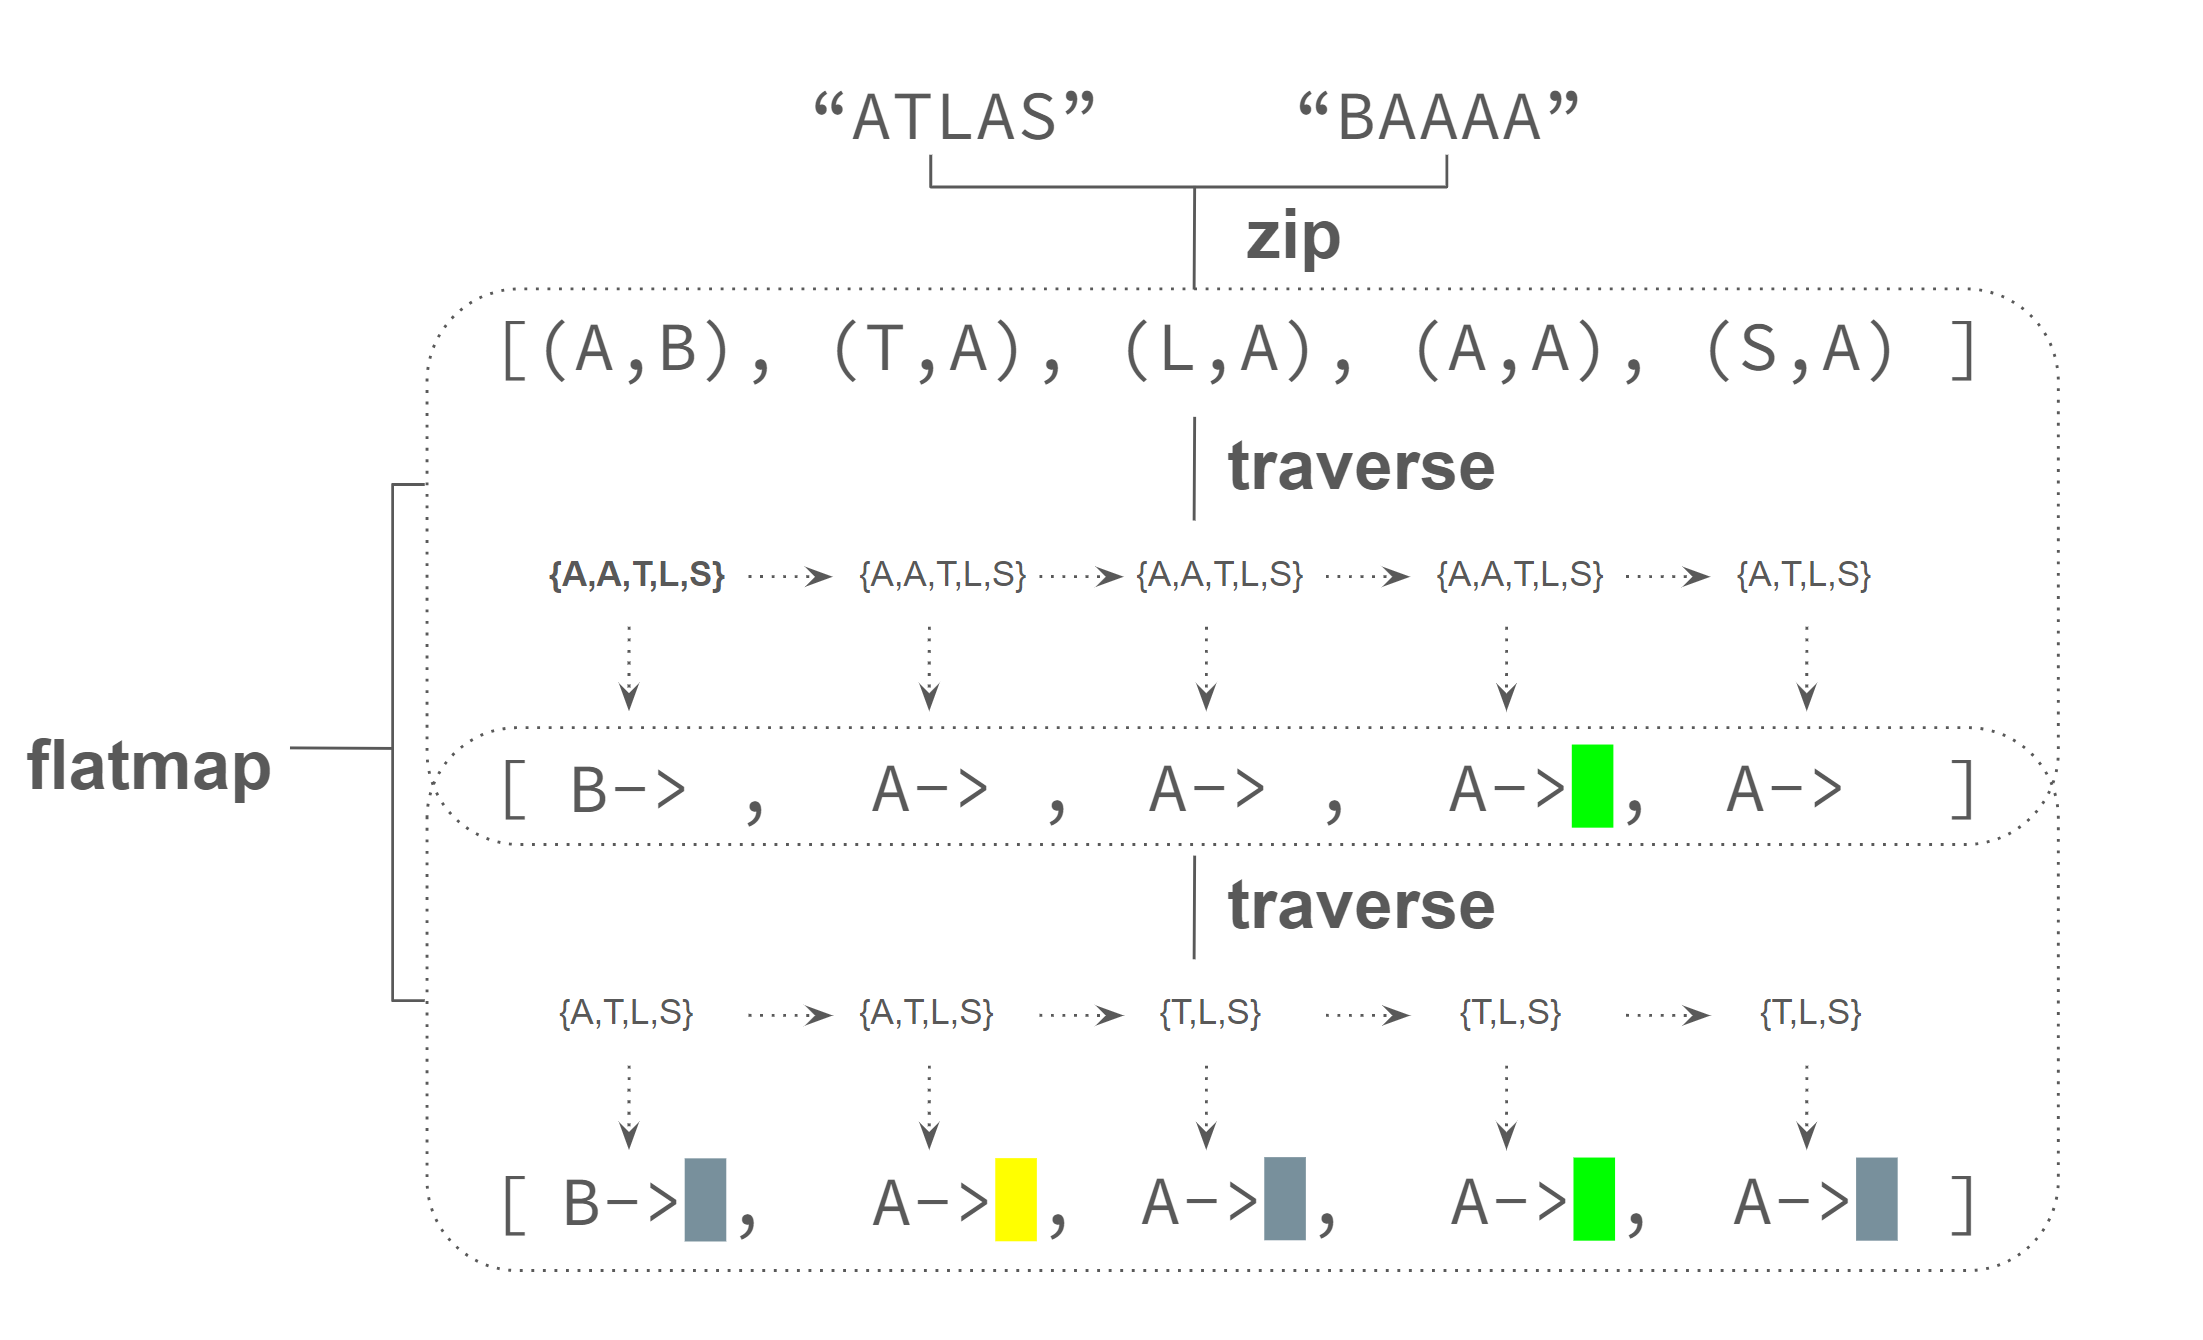

##### Cats implementation

After reviewing the last implementation, you may think that achieving declarative implementations is an ardous task: we don't only need to understand higher-level abstractions like state-transformations, traversals, etc., but also to implement these abstractions ourselves. Well, while we can't avoid the understanding part, we can certainly be dispensed with the implementation one, since these abstractions are already implemented by functional libraries like [cats](https://github.com/typelevel/cats). You can find below the implementation of the tile assignment function using this library.

In [ ]:
import $ivy.`org.typelevel::cats-core:2.10.0`

In [ ]:
import cats.syntax.all._, cats.data.State, State._

In [ ]:
def tiles(correct: String, guess: String): Assignment =

    def remove(c: Char): State[Bag[Char], Unit] = 
        modify[Bag[Char]](_ rm c)

    (correct zip guess).toList
        .traverse:
            case (c1, c2) if c1 == c2 => 
                remove(c1).as(c1 -> Option(Green))
            case (_, c) => 
                pure(c -> None)
        .flatMap:
            _.traverse: 
                case (c, None) => 
                    inspect((b: Bag[Char]) => !b.contains(c)).flatMap: 
                        if _ then pure(c -> Some(Gray))
                        else remove(c).as(c -> Some(Yellow))
                case v => pure(v)
        .runA(Bag.from(correct))
        .value

In [ ]:
run(TileTest(tiles))

### The dynamics of the game

In this section we deal with the creation and the evolution of the game state described previously. Conceptually, the following operations related to the game state can be identified: 
* Creating the initial game state. We have to provide a dictionary and the correct word to be guessed. 
* Providing a new guess. The player may attempt to guess the correct word, but if the game was already over or the word is not in the dictionary, an error should be returned; otherwise, a new game state will be returned together with the tile assignment of the input guess. 

In [ ]:
// start game

// Attempt Error type

// attempt 



We can then simulate the game as follows: 

In [ ]:
val game0: Wordle = start("SLICE", List("CRANE", "PIOUS", "SLICE"))
val Right(game1, assignment1) = attempt("CRANE")(game0): @unchecked
assignment1
val Right(game2, assignment2) = attempt("PIOUS")(game1): @unchecked
assignment2
val Right(game3, assignment3) = attempt("SLICE")(game2): @unchecked
assignment3

### User interface

The user interface module deals with the interaction between the player and the machine. In order to test the user interface we recommend executing the accompanying sbt project. In order to do so, you will first have to install the [`sbt` build tool](https://www.scala-sbt.org/), and then simply execute `sbt run` from the command line. Alternatively, you can also run the application through [VS Code or Intellij](https://docs.scala-lang.org/getting-started/index.html#open-hello-world-project). 

##### The dictionary

Before explaining the user interface itself, we have to add some functionality related to the dictionary. Namely, how to create the dictionary and how to extract a sample word randomly.

In [ ]:
import scala.util.Try

object Dictionary:
    def apply(file: String): Try[Dictionary] = 
        Try(scala.io.Source.fromResource(file).getLines.toList)

    extension (dict: Dictionary)
        def sample: String = 
            dict(scala.util.Random.nextInt(dict.size))

import Dictionary._

As you can see, we read the dictionary from a file located in the classpath of the project. Since the file name could be wrong we capture the potential `FileNotFound` exception with the [`Try`](https://www.scala-lang.org/api/current/scala/util/Try.html) utility (basically, `Try[T]` is isomorphic to `Either[Throwable, T]`).

In order to extract a sample word randomly, we use the `scala.util.Random` object. 

##### The user interface

The user interface is implemented by two tail-recursive functions, which make use of an auxiliary function to map the assignment into an ANSI-coloured string. 

In [ ]:
def play(dict: Dictionary): Unit = 
    println("Guess the word in six tries!")
    play(start(dict.sample, dict), 1)
    scala.io.StdIn.readLine("Would you like to play again? (y/n) ") match
        case "y" => play(dict)
        case _ => println("Goodbye!")

def play(w: Wordle, attemptNo: Int): Unit = 
    if win(w) then 
        println("You win!")
    else if lose(w) then 
        println("You lose! The correct word was: "+ w.correct)
    else 
        val guess = scala.io.StdIn.readLine(s"GUESS $attemptNo: ")
        attempt(guess)(w) match
            case Left(AttemptError.WrongWord) => 
                println("Not in my dictionary! Try again, please.")
                play(w, attemptNo)
            case Left(AttemptError.IsOver) =>
                println("Game is already over!")
            case Right(w, assignment) =>
                println(ansi(assignment))
                play(w, attemptNo + 1)

import Console.{GREEN_B, MAGENTA_B, RESET, YELLOW_B}

def ansi(assignment: Assignment): String = 
    ???

##### The main function

The main function simply creates the dictionary and launch the main function of the user interface. 

In [ ]:
import scala.util.{Success, Failure}

def main(): Unit =
  Dictionary("word.txt") match 
    case Failure(error) => println(error)
    case Success(dict) => play(dict) 